<a href="https://colab.research.google.com/github/bavya-sri/Rasmalai/blob/Final/ModelComparisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,MaxPool2D,Conv2D,UpSampling2D,Activation,BatchNormalization,Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import datetime
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_files=['/content/drive/MyDrive/DataScience/patches-train/train/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-train/train/')]
test_files=['/content/drive/MyDrive/DataScience/patches-test/test/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-test/test/')]

In [7]:
def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [8]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50] 

#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [9]:
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)

Shape of single batch of x :  (64, 40, 40, 3)
Shape of single batch of y :  (64, 40, 40, 3)


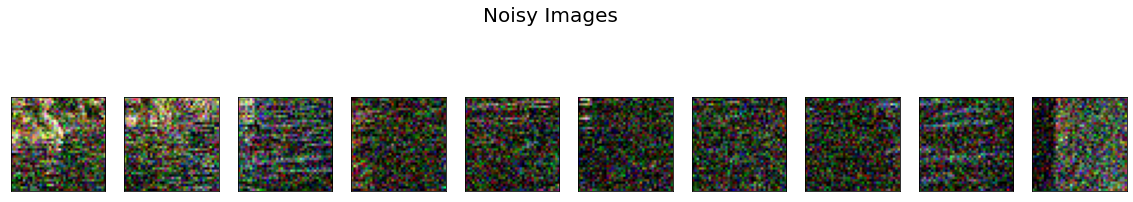

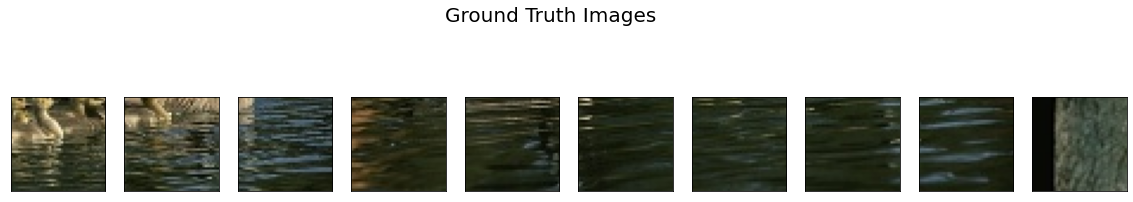

In [10]:
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(a[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Noisy Images',fontsize=20)
plt.show()
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(b[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Ground Truth Images',fontsize=20)
plt.show()

In [11]:
def get_patches(file_name,patch_size,crop_sizes):
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: 
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] 
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  image=np.zeros(image_shape) 
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] 
      p+=1
  return np.array(image)

def predict_fun(model,image_path,noise_level=30):
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


def PSNR(gt, image, max_value=1):
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [12]:
dncnn=tf.keras.models.load_model('/content/drive/MyDrive/DataScience/dncnn.h5')
autoencoder=tf.keras.models.load_model('/content/drive/MyDrive/DataScience/autoencoder.h5')
ridnet = tf.keras.models.load_model('/content/drive/MyDrive/DataScience/ridnet.h5')

In [20]:
results=pd.DataFrame(columns=['Noise Level','Noise Image','AutoEncoder','DnCNN','RIDNET'])

In [24]:
def get_results(results,noise_level):

  patches_noisy_a,denoised_patches_a,ground_truth,noisy_image_a,denoised_image_a=predict_fun(ridnet,'/content/drive/MyDrive/DataScience/test/163096.jpg',noise_level=noise_level)
  patches_noisy_d,denoised_patches_d,ground_truth,noisy_image_d,denoised_image_d=predict_fun(dncnn,'/content/drive/MyDrive/DataScience/test/163096.jpg',noise_level=noise_level)
  patches_noisy_r,denoised_patches_r,ground_truth,noisy_image_r,denoised_image_r=predict_fun(ridnet,'/content/drive/MyDrive/DataScience/test/163096.jpg',noise_level=noise_level)
  results.loc[len(results.index)]=[noise_level,PSNR(ground_truth,noisy_image_a),PSNR(ground_truth,denoised_image_a)
                                                    ,PSNR(ground_truth,denoised_image_d),PSNR(ground_truth,denoised_image_r)]

  return results

In [22]:
results=get_results(results,15)
results=get_results(results,20)
results=get_results(results,25)
results=get_results(results,30)
results=get_results(results,40)
results=get_results(results,45)

3/3 [==============================] - 0s 12ms/step


In [23]:
print('Tabulating the model results with different noise level \n')
results.head(6)

Tabulating the model results with different noise level 



,Noise Level,Noise Image,AutoEncoder,DnCNN,RIDNET
0,15.0,25.003917,27.718060,29.200819,32.718259
1,20.0,22.568903,25.274728,26.673549,30.225380
2,25.0,20.721881,22.476120,24.565213,27.479098
3,30.0,19.214351,20.101535,22.738018,25.061061
4,40.0,16.914617,16.721643,19.862525,21.674023
5,45.0,15.990168,15.418985,18.658122,20.417471
